# Sentiment Analysis: Negative review detection

Description of each feature in the dataset:
1. tconst: This is an alphanumeric unique identifier for each title in the dataset, typically used by IMDb.

2. title_type: Indicates the format of the title, e.g., movie, short film, etc.

3. primary_title: The main title by which the movie or show is known.

4. original_title: The original title in the movie's or show's original language.

5. start_year: The year in which the title was released or started airing.

6. end_year: The year in which the title ended, especially relevant for TV series. If the value is \N, it indicates that the end year is not applicable, often for movies.

7. runtime_minutes: The duration of the movie in minutes.

8. is_adult: A binary indicator (0 or 1) where 0 means the title is not adult content, and 1 indicates it is adult content.

9. genres: A comma-separated list of genres applicable to the title.

10. average_rating: The average rating of the title on IMDb.

11. votes: The number of votes the title has received on IMDb.

12. review: A text review provided by a user for the title.

13. rating: A numerical rating provided by the reviewer, which seems to be separate from the average_rating.

14. sp: Sentiment polarity; indicating the sentiment of the review, either negative (neg) or positive (pos).

15. pos: Indicates if the review is positive or negative. '0' indicates negative review and '1' indicates positive revire

16. ds_part: Indicates which part of the dataset the record belongs to, for example, 'train' for training set or 'test' for testing set.

17. idx: A unique identifier or index for each row in this particular sample of the dataset.

## Import Libraries and Data preprocessing

### Load Necessary Libraries

In [83]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import HTML
import sklearn.metrics as metrics
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from lightgbm import LGBMClassifier
from sklearn.ensemble import RandomForestClassifier
from tqdm import tqdm, tqdm_notebook
import nltk

#Suppress warnings
import warnings
warnings.filterwarnings("ignore")

In [84]:
#Visualization and Progress Bar Configuration
%matplotlib inline
%config InlineBackend.figure_format = 'retina'  # Enhanced display in notebooks
plt.style.use('seaborn-whitegrid') # Use a white grid theme for seaborn
tqdm.pandas(desc="Progress:")

### Load Data

In [85]:
df_reviews = pd.read_csv('/content/imdb_reviews.tsv', sep='\t')

In [86]:
#Preview the data
df_reviews.head()

,tconst,title_type,primary_title,original_title,start_year,end_year,runtime_minutes,is_adult,genres,average_rating,votes,review,rating,sp,pos,ds_part,idx
0,tt0068152,movie,$,$,1971,\N,121,0,"Comedy,Crime,Drama",6.3,2218.0,The pakage implies that Warren Beatty and Gold...,1,neg,0,train,8335
1,tt0068152,movie,$,$,1971,\N,121,0,"Comedy,Crime,Drama",6.3,2218.0,How the hell did they get this made?! Presenti...,1,neg,0,train,8336
2,tt0313150,short,'15','15',2002,\N,25,0,"Comedy,Drama,Short",6.3,184.0,There is no real story the film seems more lik...,3,neg,0,test,2489
3,tt0313150,short,'15','15',2002,\N,25,0,"Comedy,Drama,Short",6.3,184.0,Um .... a serious film about troubled teens in...,7,pos,1,test,9280
4,tt0313150,short,'15','15',2002,\N,25,0,"Comedy,Drama,Short",6.3,184.0,I'm totally agree with GarryJohal from Singapo...,9,pos,1,test,9281


For our sentiment analysis, only the textual content of the 'review' and the binary sentiment 'pos' are important. Thus, we will streamline our data preprocessing to focus exclusively on these two columns.

### Preprocess Data

#### Check for Missing Values

In [87]:
# Identify and display missing entries in 'review' and 'pos' columns for sentiment analysis.
print("Overview of missing data in 'review' and 'pos' columns:")
df_reviews[['review', 'pos']].isnull().sum().to_frame().rename(columns={0: 'Missing Values'})

Overview of missing data in 'review' and 'pos' columns:


,Missing Values
review,0
pos,0


There are no any missing values in 'review' and 'pos' columns

#### Check for Duplicates

In [88]:
#Print total number of duplicated rows.
print(f'Total number of duplicate rows: {df_reviews.duplicated().sum()}')

Total number of duplicate rows: 0


#### Check Datatypes

In [89]:
# Review the assigned data types for each column, focusing on analysis-relevant fields.
print("Data types in the dataset:")
df_reviews.dtypes

Data types in the dataset:


tconst              object
title_type          object
primary_title       object
original_title      object
start_year           int64
end_year            object
runtime_minutes     object
is_adult             int64
genres              object
average_rating     float64
votes              float64
review              object
rating               int64
sp                  object
pos                  int64
ds_part             object
idx                  int64
dtype: object

The 'review' column is formatted as an object and the 'pos' column as an int64. This formatting is suitable for the training and evaluation of our machine learning model.

#### Removing Unnecessary Characters from 'review' column

In [90]:
# Define function to retain only alphabets and apostrophes in 'review' column.
def filter_characters(df):
    """
    This function keeps only letters and apostrophes in the text.
    """
    filtered = re.sub(r"[^a-zA-Z']", " ", df).split()
    filtered = " ".join(filtered).lower()
    return filtered

# Execute the function on each review in the DataFrame
df_reviews['normalized_review'] = df_reviews['review'].apply(filter_characters)

To optimize the performance of the models we're training and to ensure predictions are based solely on words, phrases, and terms, we have eliminated all characters from each review except letters and apostrophes. Additionally, we converted all text to lowercase.

## EDA

To gain a deeper understanding of our data, we will start by analyzing the total number of movies released and reviews created each year.

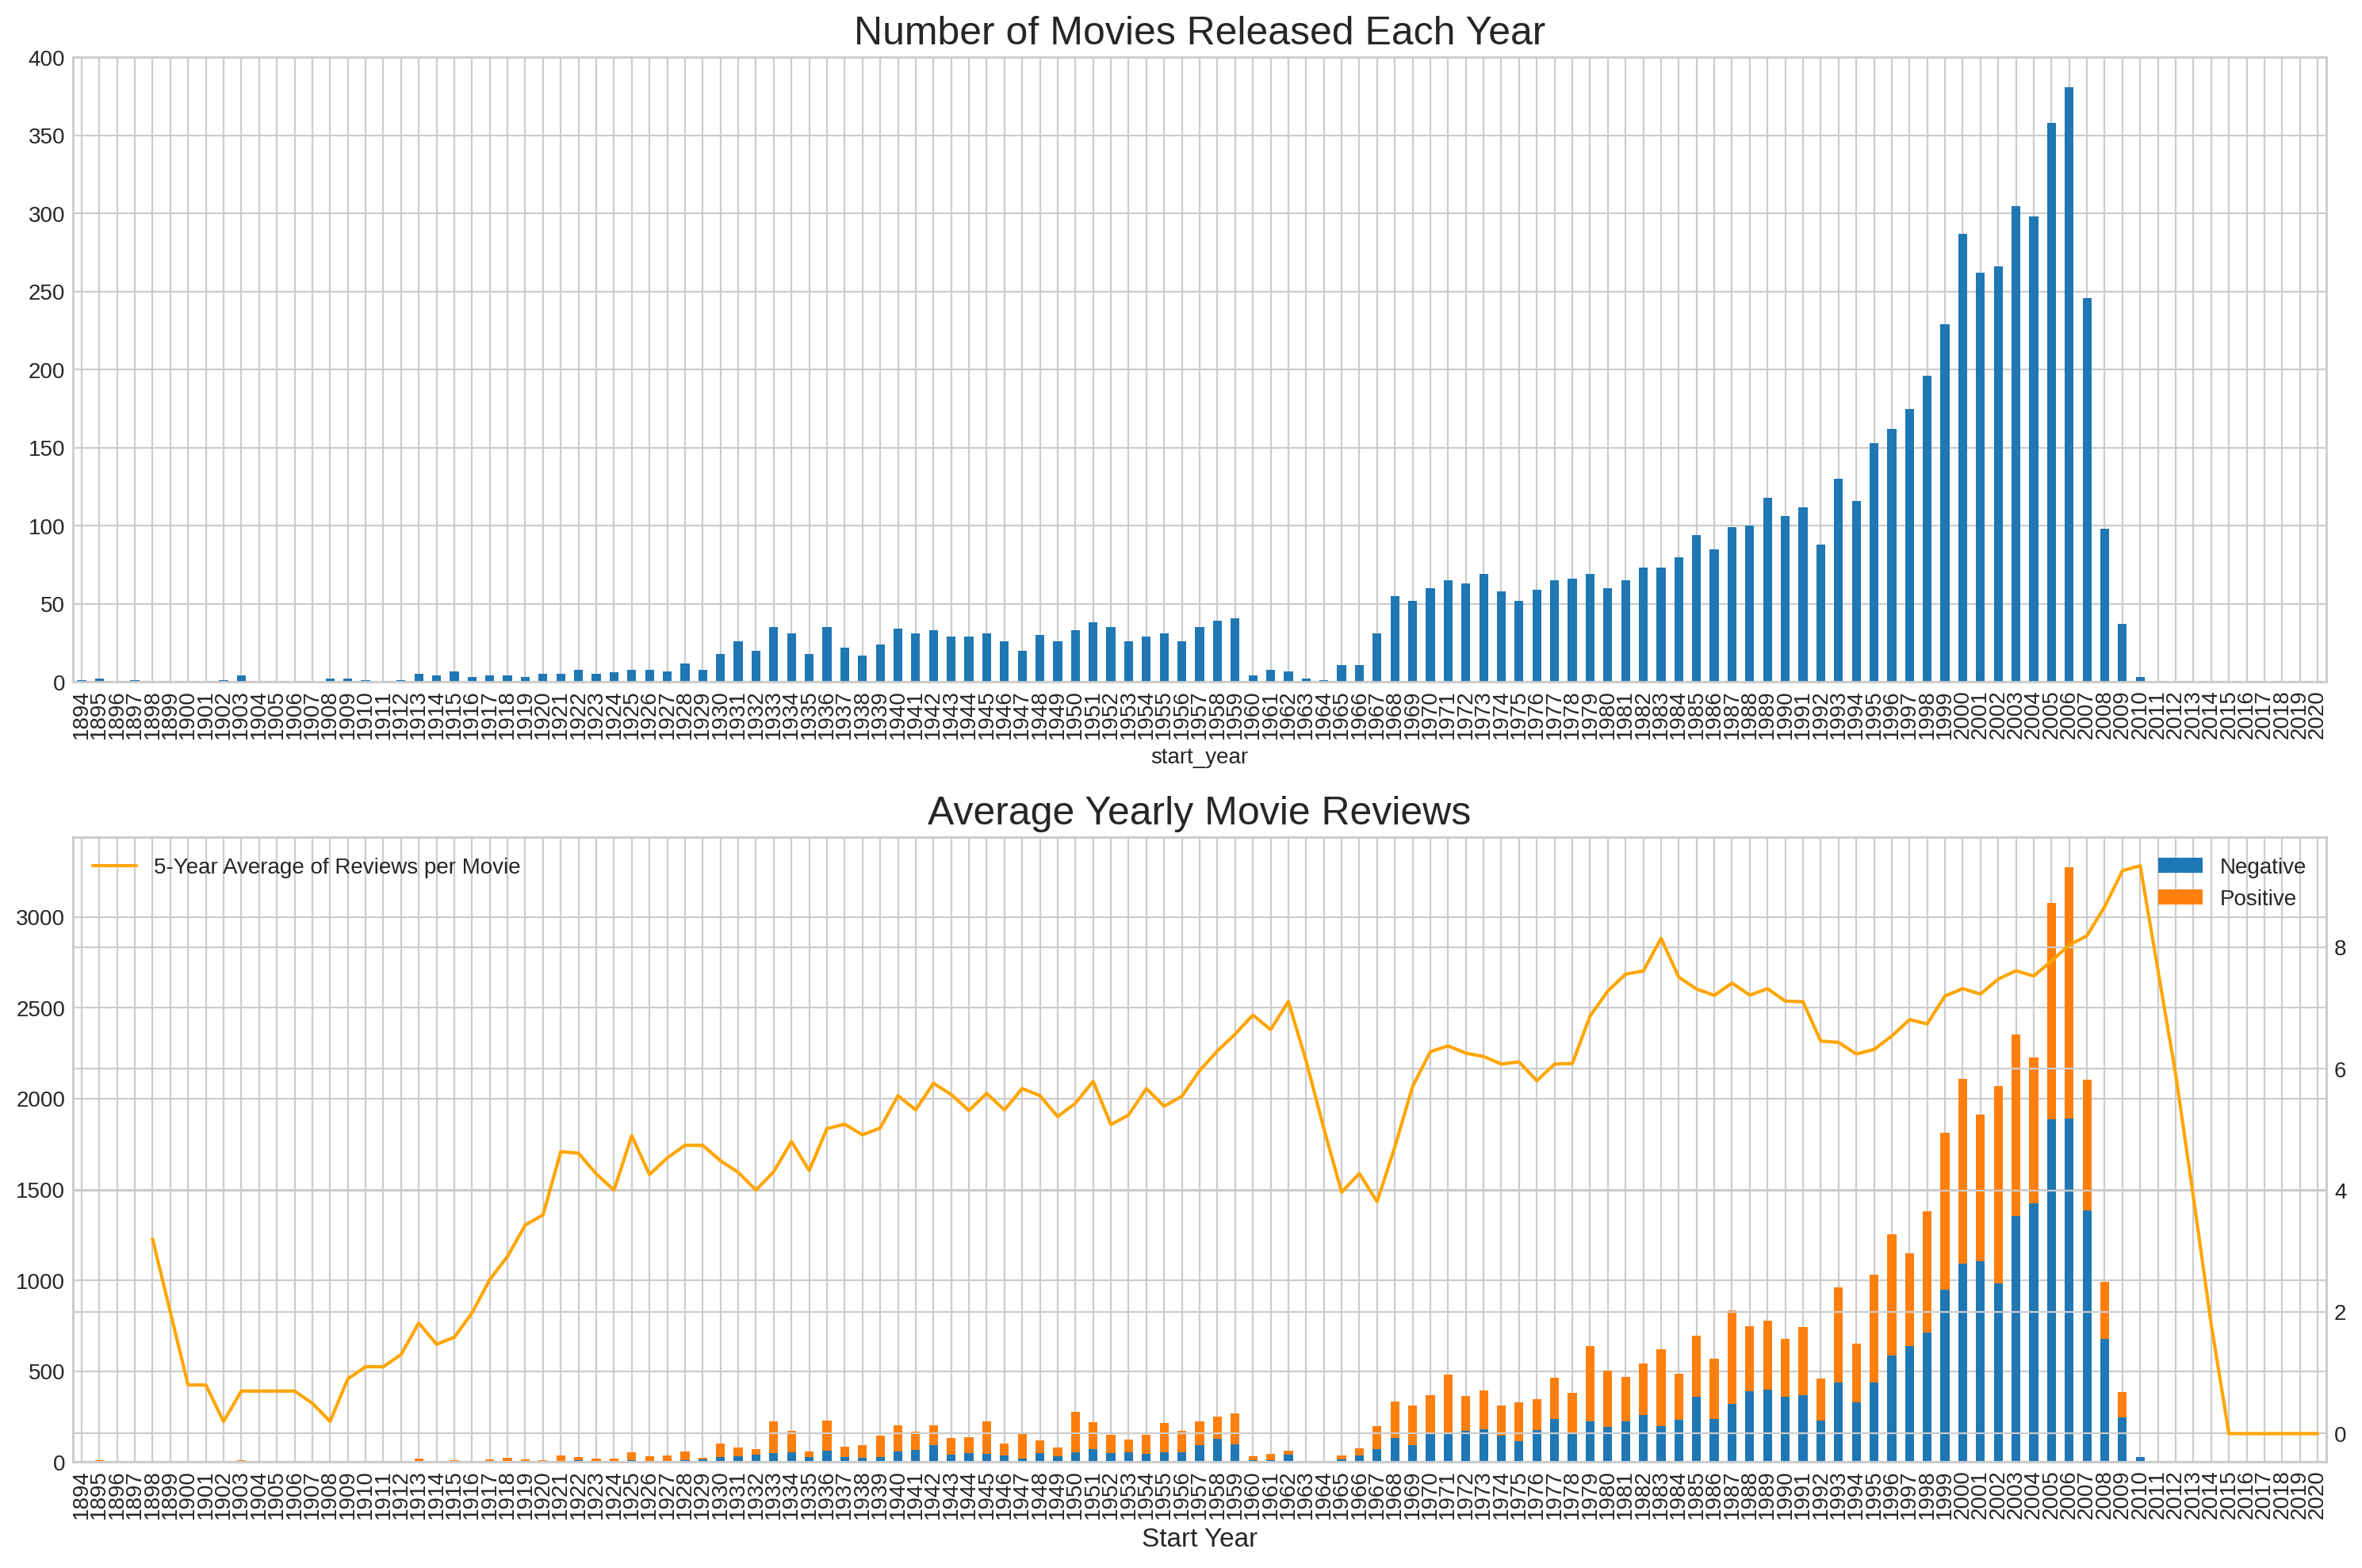

In [91]:
# Initialize a figure with subplots.
fig, axs = plt.subplots(2, 1, figsize=(15, 10))

# Configure the first subplot.
ax = axs[0]

# Plot the number of movies released annually.
dft1 = df_reviews[['tconst', 'start_year']].drop_duplicates() \
    ['start_year'].value_counts().sort_index()
dft1 = dft1.reindex(index=np.arange(dft1.index.min(), max(dft1.index.max(), 2021))).fillna(0)
dft1.plot(kind='bar', ax=ax)
ax.set_title('Number of Movies Released Each Year', fontsize=18)

# Configure the second subplot.
ax = axs[1]

# Plot the number of reviews each year, categorized by sentiment.
dft2 = df_reviews.groupby(['start_year', 'pos'])['pos'].count().unstack()
dft2 = dft2.reindex(index=np.arange(dft2.index.min(), max(dft2.index.max(), 2021))).fillna(0)
dft2.plot(kind='bar', stacked=True, ax=ax, label=['Negative', 'Positive'])
axs[1].legend(labels=['Negative', 'Positive'], loc=0)

# Add a line plot for the rolling average (5-year) of reviews per movie.
dft2_total_reviews = df_reviews['start_year'].value_counts().sort_index()
dft2_total_reviews = dft2_total_reviews.reindex(index=np.arange(dft2_total_reviews.index.min(), max(dft2_total_reviews.index.max(), 2021))).fillna(0)
reviews_per_movie_avg = (dft2_total_reviews / dft1).fillna(0)
axt = ax.twinx()
reviews_per_movie_avg.reset_index(drop=True).rolling(5).mean().plot(color='orange', label='5-Year Average of Reviews per Movie', ax=axt)
axt.legend(loc=0)
ax.set_title('Average Yearly Movie Reviews', fontsize=18)
ax.set_xlabel('Start Year', fontsize=12)
fig.tight_layout()

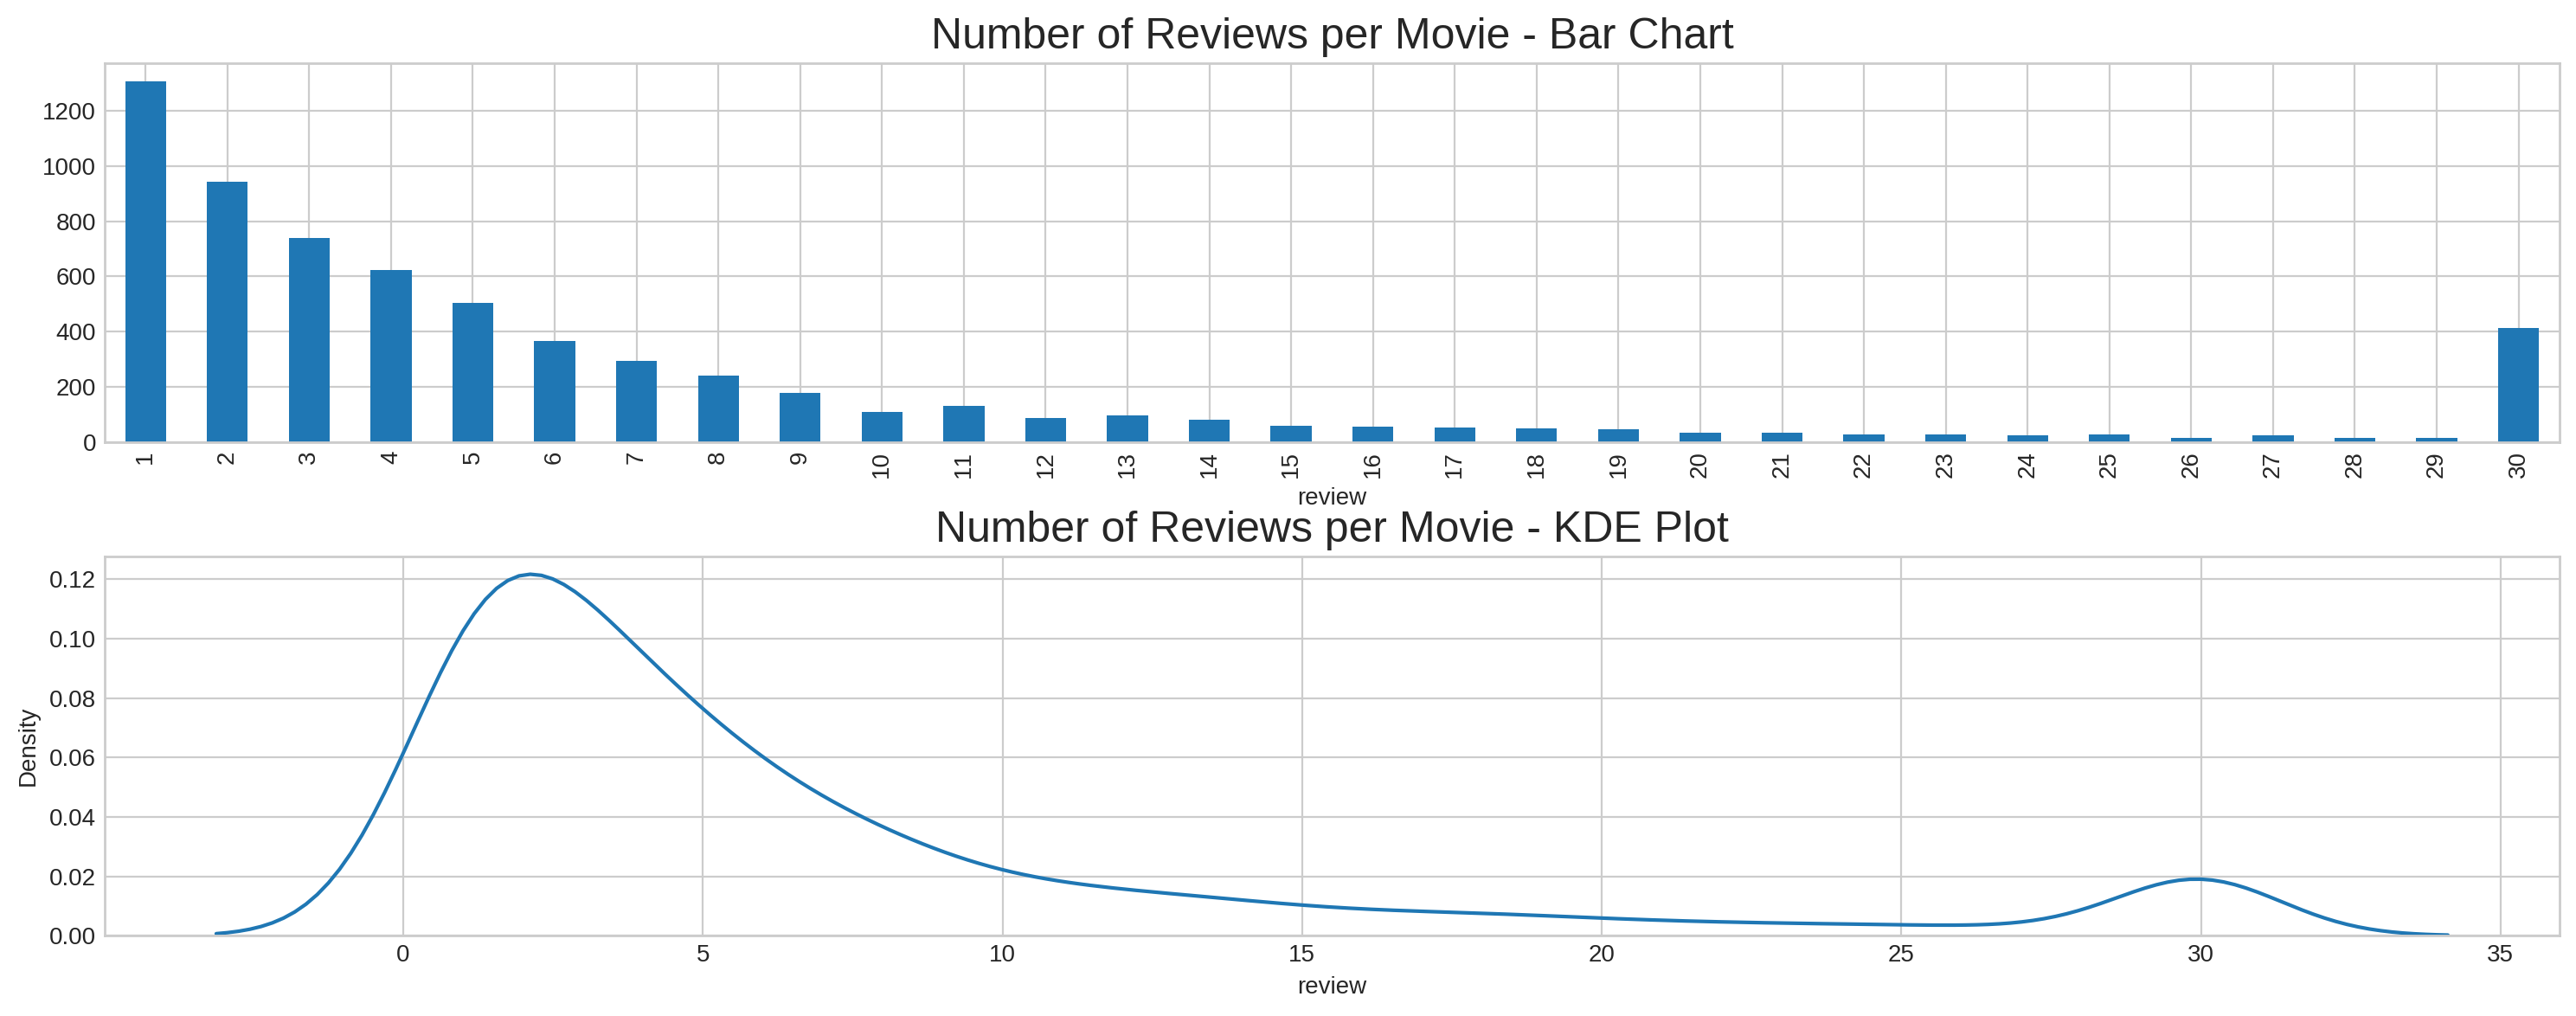

In [92]:
# Initialize a figure with two subplots.
fig, axs = plt.subplots(2, 1, figsize=(15, 6))

# Configure the first subplot for the bar chart.
ax = axs[0]

# Aggregate movies by their title identifier and count reviews, then plot the results.
dft = df_reviews.groupby('tconst')['review'].count() \
    .value_counts() \
    .sort_index()
dft.plot(kind='bar', ax=ax)
ax.set_title('Number of Reviews per Movie - Bar Chart', fontsize=18)

# Configure the second subplot for the KDE plot.
ax = axs[1]

# Calculate the distribution of review counts per movie and plot a KDE.
review_counts = df_reviews.groupby('tconst')['review'].count()
sns.kdeplot(review_counts, ax=ax)
ax.set_title('Number of Reviews per Movie - KDE Plot', fontsize=18)

# Adjust layout and spacing.
fig.tight_layout()
fig.subplots_adjust(hspace=0.3)  # Increase spacing between rows of subplots
plt.show()


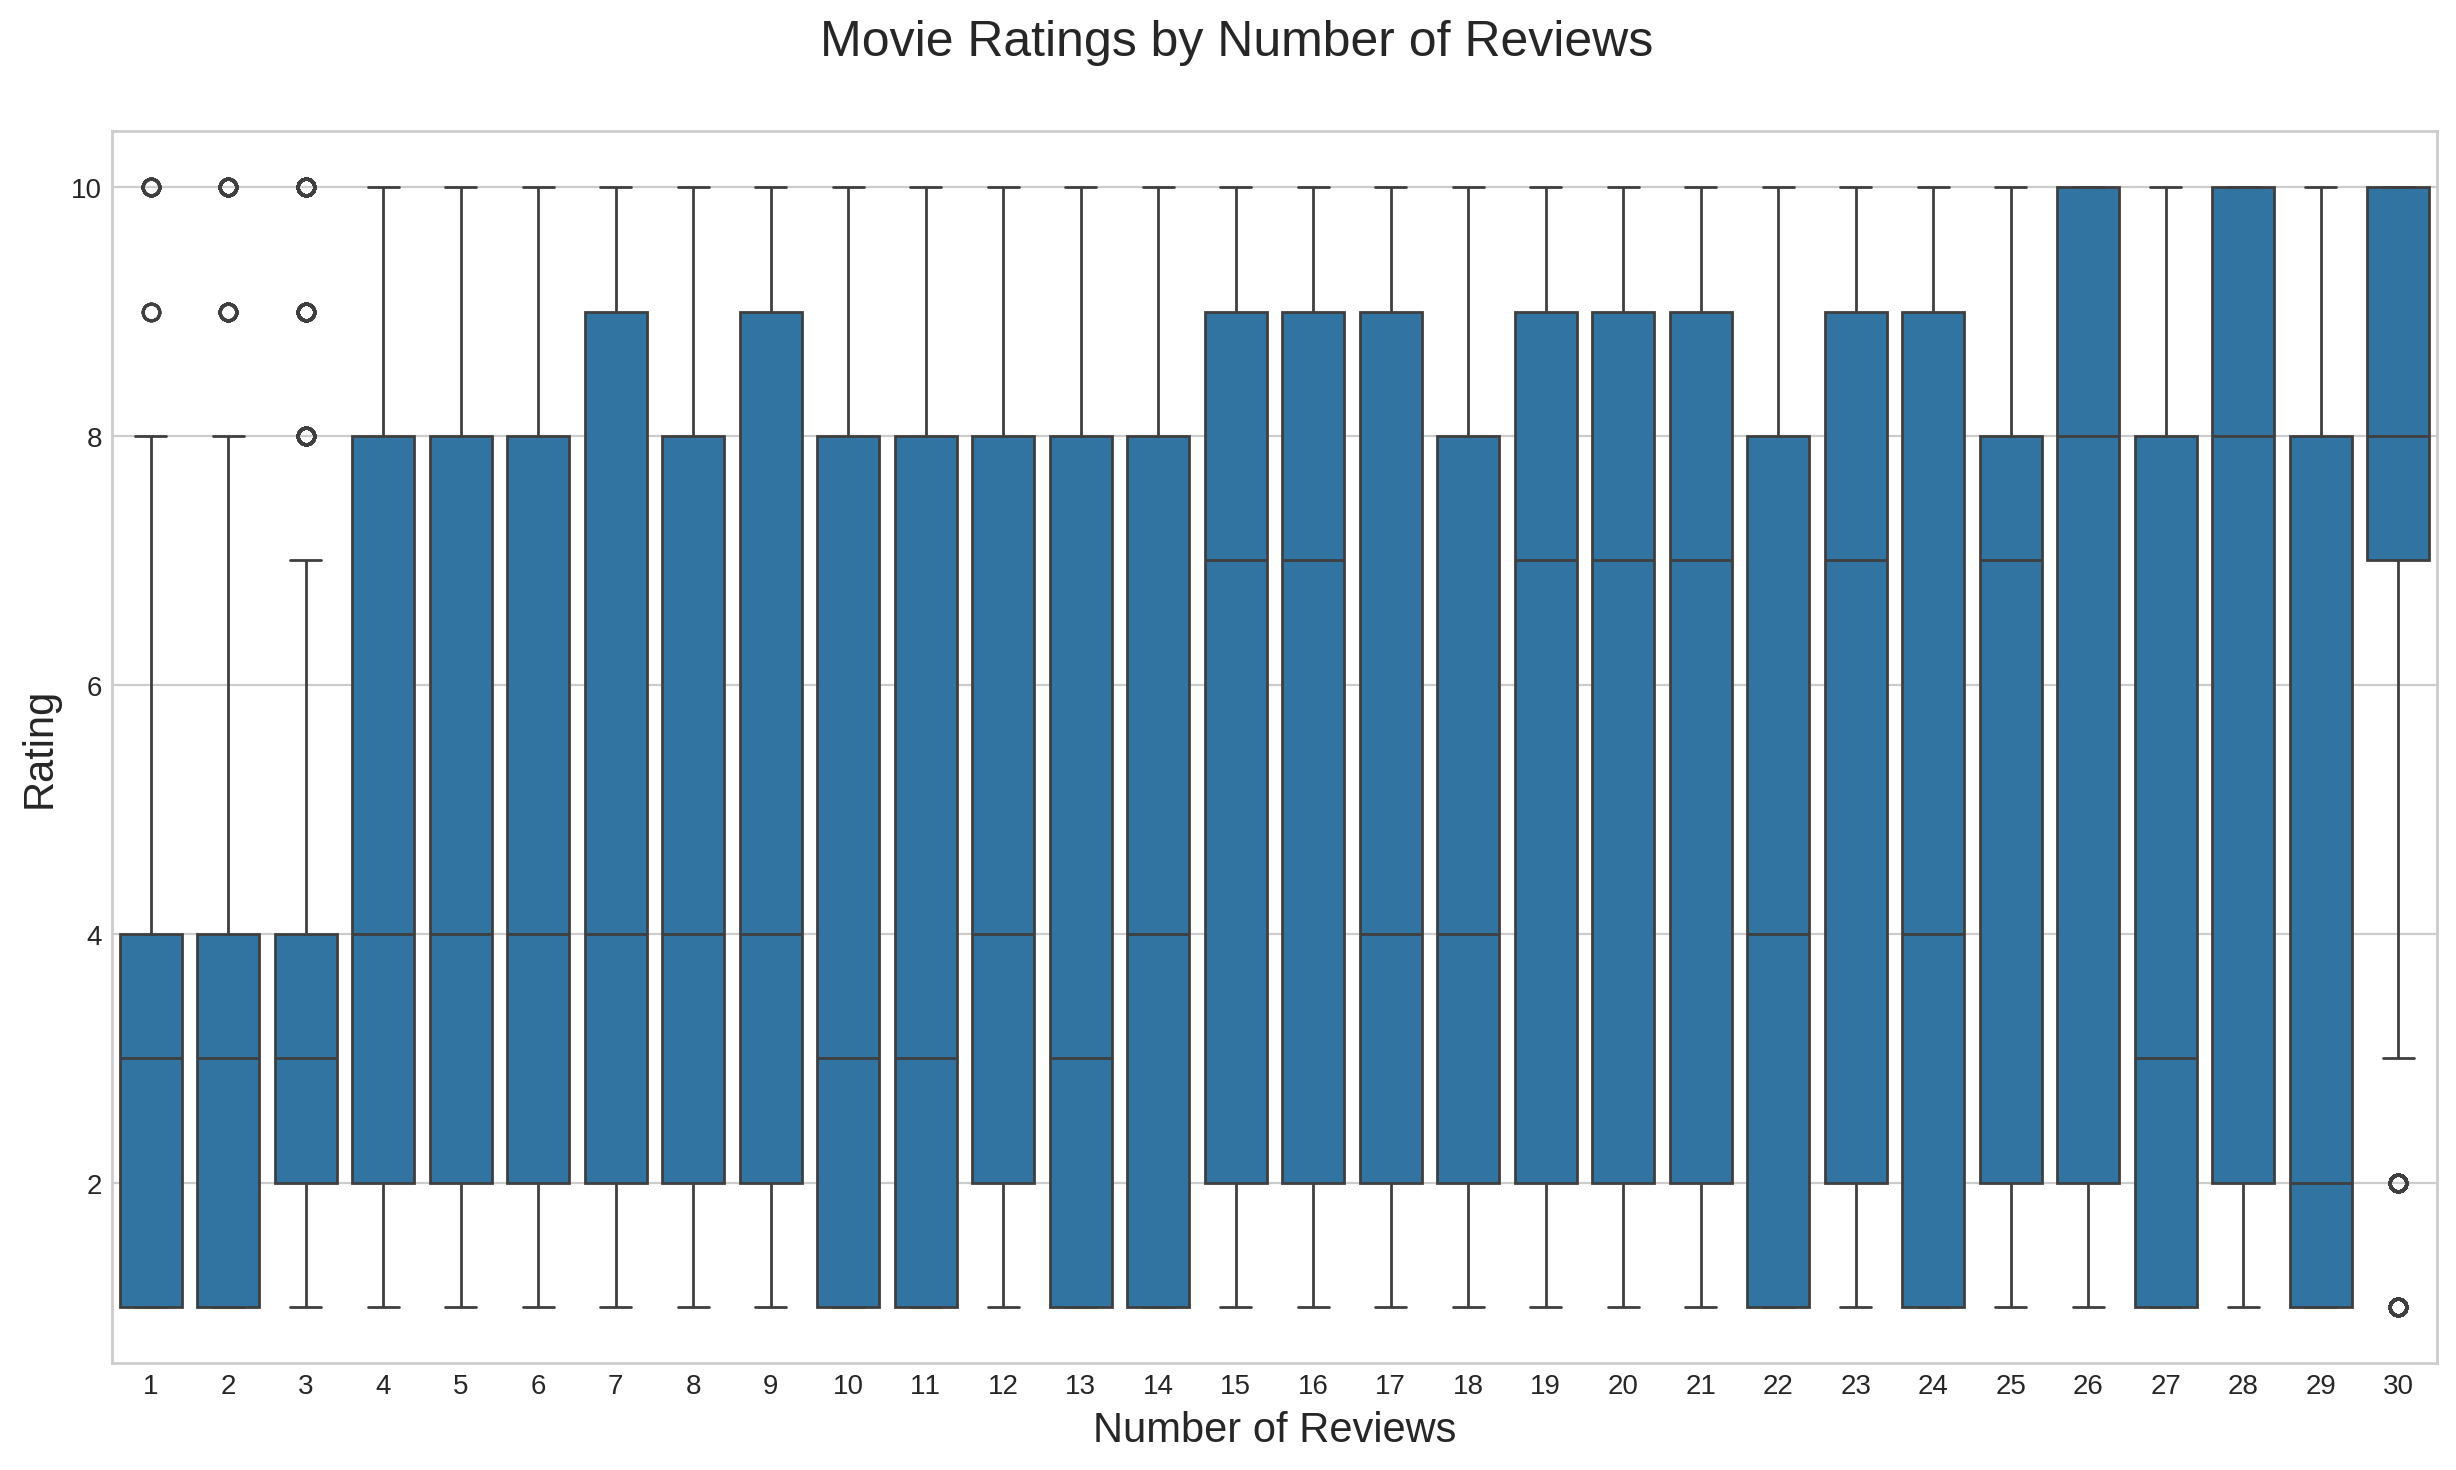

In [93]:
# Generate a new column to count the total reviews for each movie.
df_reviews['review_count'] = df_reviews.groupby('tconst')['review'].transform('count')

# Create a boxplot to visualize the distribution and average of movie ratings based on the number of reviews.
fig = plt.figure(figsize=(15, 8))
sns.boxplot(x="review_count", y="rating", data=df_reviews[['review_count', 'rating']])
fig.suptitle('Movie Ratings by Number of Reviews', fontsize=18, y=.95)
plt.xlabel('Number of Reviews', fontsize=15)
plt.ylabel('Rating', fontsize=15)
plt.show()

### Distribution of positive and Negative Reviews

In [94]:
# Display the count of positive and negative reviews in the dataset.
print("Count of positive and negative reviews in the full dataset:")
display(df_reviews['pos'].value_counts().reset_index(drop=True))

print('\nCount of positive and negative reviews in the training set:')
display(df_reviews[df_reviews['ds_part'] == "train"]['pos'].value_counts().reset_index(drop=True))

print('\nCount of positive and negative reviews in the testing set:')
display(df_reviews[df_reviews['ds_part'] == "test"]['pos'].value_counts().reset_index(drop=True))

Count of positive and negative reviews in the full dataset:


0    23715
1    23616
Name: count, dtype: int64


Count of positive and negative reviews in the training set:


0    11912
1    11884
Name: count, dtype: int64


Count of positive and negative reviews in the testing set:


0    11803
1    11732
Name: count, dtype: int64

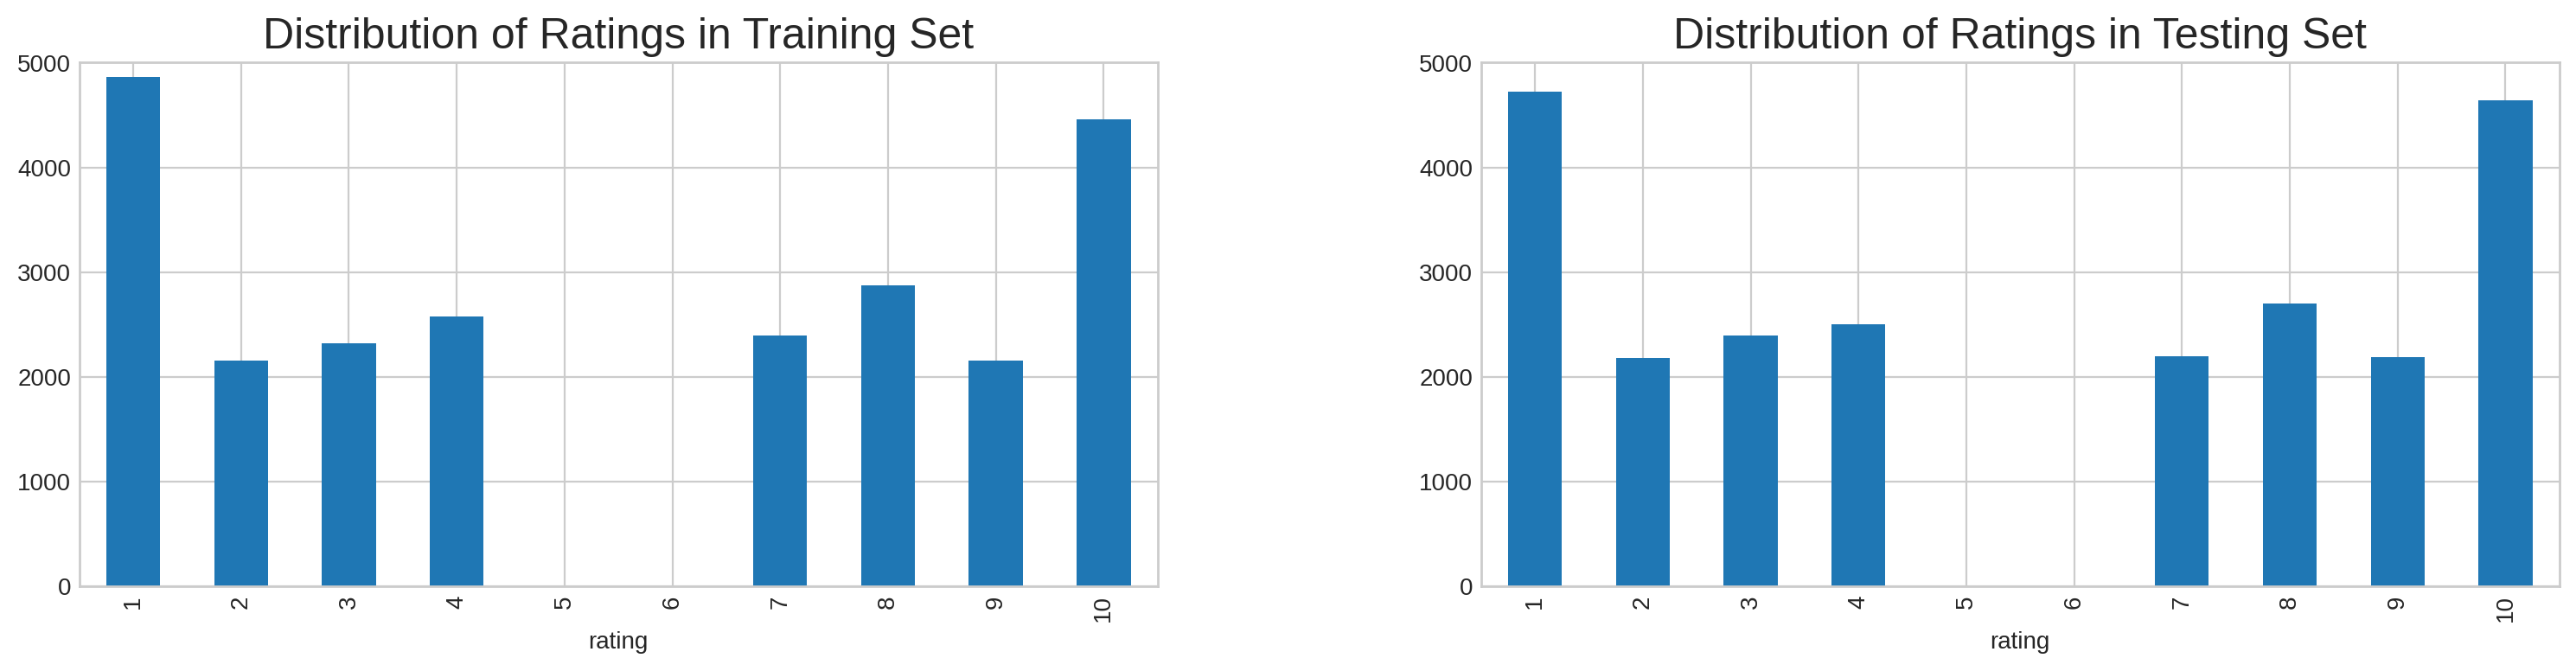

In [95]:
# Set up a figure with two subplots
fig, axs = plt.subplots(1, 2, figsize=(15, 4))

# Configure the first subplot.
ax = axs[0]

# Gather and plot the frequency of ratings in the training dataset.
dft_train = df_reviews.query('ds_part == "train"')['rating'].value_counts().sort_index()
dft_train = dft_train.reindex(index=np.arange(min(dft_train.index.min(), 1), max(dft_train.index.max(), 11))).fillna(0)
dft_train.plot(kind='bar', ax=ax)
ax.set_ylim([0, 5000])
ax.set_title('Distribution of Ratings in Training Set', fontsize=18)

# Configure the second subplot.
ax = axs[1]

# Gather and plot the frequency of ratings in the testing dataset.
dft_test = df_reviews.query('ds_part == "test"')['rating'].value_counts().sort_index()
dft_test = dft_test.reindex(index=np.arange(min(dft_test.index.min(), 1), max(dft_test.index.max(), 11))).fillna(0)
dft_test.plot(kind='bar', ax=ax)
ax.set_ylim([0, 5000])
ax.set_title('Distribution of Ratings in Testing Set', fontsize=18)

# Adjust the layout and spacing between plots.
fig.tight_layout()
fig.subplots_adjust(wspace=0.3)
plt.show()


## Creating Model Evaluation Funtion

In [96]:
# Define a function to assess performance metrics of models.
def assess_model_metrics(model_name, model, features_train, labels_train, features_test, labels_test):

    # Initialize dictionary to store evaluation results.
    evaluation_results = {}

    # Loop to process both training and testing data.
    for data_type, features, labels in (('Training', features_train, labels_train), ('Testing', features_test, labels_test)):

        # Initialize sub-dictionary for results per data set.
        evaluation_results[data_type] = {}

        # Generate predictions from the model.
        predicted_labels = model.predict(features)
        # Compute probabilities for the positive class.
        predicted_probs = model.predict_proba(features)[:, 1]

        # Calculate F1 scores across a spectrum of thresholds.
        thresholds = np.arange(0, 1.01, 0.05)
        f1_values = [metrics.f1_score(labels, predicted_probs >= t) for t in thresholds]

        # Calculate and record the ROC AUC score.
        fpr, tpr, _ = metrics.roc_curve(labels, predicted_probs)
        roc_auc_value = metrics.roc_auc_score(labels, predicted_probs)
        evaluation_results[data_type]['ROC AUC'] = roc_auc_value

        # Record accuracy and F1 score.
        evaluation_results[data_type]['Accuracy'] = metrics.accuracy_score(labels, predicted_labels)
        evaluation_results[data_type]['F1'] = metrics.f1_score(labels, predicted_labels)

    # Convert results into a DataFrame for better visualization.
    results_df = pd.DataFrame(evaluation_results)
    results_df = results_df.round(2)
    results_df = results_df.reindex(index=('Accuracy', 'F1', 'ROC AUC'))

    # Display the DataFrame.
    display(HTML(f'<b>Results for {model_name}:</b>'))
    display(results_df)

    return

## Split Data into Train and Test

In [97]:
# Divide data into training and testing sets based on the 'ds_part' attribute.
training_data = df_reviews.query('ds_part == "train"').copy()
testing_data = df_reviews.query('ds_part == "test"').copy()

# Extract target values for both training and testing datasets.
train_targets = training_data['pos']
test_targets = testing_data['pos']

# Extract features from the datasets.
train_features = training_data.normalized_review
test_features = testing_data.normalized_review

# Output the dimensions of both the training and testing datasets.
print(f'Shape of the training data: {training_data.shape}')
print(f'Shape of the testing data: {testing_data.shape}')

Shape of the training data: (23796, 19)
Shape of the testing data: (23535, 19)


## Training and Testing Models

### Model 1 - Linear Regression

In [98]:
# Define a function to perform lemmatization
def lemmatize_text(text):
    # Instantiate a lemmatizer.
    lemmatizer = WordNetLemmatizer()
    # Tokenize the text into words.
    tokens = nltk.word_tokenize(text)
    # Apply lemmatization to each word and combine them back into a single string.
    lemmatized_output = ' '.join([lemmatizer.lemmatize(word) for word in tokens])
    return lemmatized_output

In [99]:
# Apply lemmatization to the training and testing feature sets.

# Ensure required nltk resources are available.
nltk.download('punkt')
nltk.download('wordnet')

train_X_lemmatized_nltk = train_X.progress_apply(lemmatize_text)
test_X_lemmatized_nltk = test_X.progress_apply(lemmatize_text)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
Progress:: 100%|██████████| 23535/23535 [00:46<00:00, 509.78it/s]


In [100]:
# Ensure required nltk resources are available.
nltk.download('stopwords')

# Establish a list of English stop words.
english_stop_words = list(stopwords.words('english'))

# Initialize a TF-IDF vectorizer with the stop words list.
tfidf_vectorizer = TfidfVectorizer(stop_words=english_stop_words)

# Fit the vectorizer to the lemmatized training data and transform both training and testing datasets.
train_X_tfidf = tfidf_vectorizer.fit_transform(train_X_lemmatized_nltk)
test_X_tfidf = tfidf_vectorizer.transform(test_X_lemmatized_nltk)

# Instantiate and train a logistic regression model.
logistic_model = LogisticRegression(random_state=12345, solver='saga')
logistic_model.fit(train_X_tfidf, train_targets)

# Assess the performance of the logistic regression model.
assess_model_metrics('Logistic Regression', logistic_model, train_X_tfidf, train_targets, test_X_tfidf, test_targets)

# # Clean up memory by removing large temporary variables.
# del train_X_lemmatized_nltk, test_X_lemmatized_nltk

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


,Training,Testing
Accuracy,0.94,0.88
F1,0.94,0.88
ROC AUC,0.98,0.95


### Model 2 - LGBMClassifier

In [101]:
# Instantiate and train a lgbm classifier model.
lgbm_model = LGBMClassifier(random_state=12345)
lgbm_model.fit(train_X_tfidf, train_targets)

# Assess the performance of the lgbm classifier model.
assess_model_metrics('lgbm classifier', lgbm_model, train_X_tfidf, train_targets, test_X_tfidf, test_targets)

[LightGBM] [Info] Number of positive: 11884, number of negative: 11912
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 6.612326 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 491157
[LightGBM] [Info] Number of data points in the train set: 23796, number of used features: 10417
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.499412 -> initscore=-0.002353
[LightGBM] [Info] Start training from score -0.002353


,Training,Testing
Accuracy,0.92,0.86
F1,0.92,0.86
ROC AUC,0.97,0.94


###  Model 3 - Random Forest Classifier

In [102]:
# Instantiate and train a Random Forest classifier.
random_forest_model = RandomForestClassifier(random_state=12345)
random_forest_model.fit(train_X_tfidf, train_targets)

# Assess the performance of the Random Forest classifier.
assess_model_metrics('Random Forest Classifier', random_forest_model, train_X_tfidf, train_targets, test_X_tfidf, test_targets)

,Training,Testing
Accuracy,1.0,0.85
F1,1.0,0.85
ROC AUC,1.0,0.93


## Conclusion

Our results of training and evaluating three different models(Logistic Regression, LGBM classifier and Random Forest Classifier) show that Logistic Regression is the most reliable across both training and real-world scenarios, with high scores for accuracy and consistency. It performed well, not just on the data it was trained on but also on new, unseen data.

The LGBM Classifier also performed well, though it slightly lagged behind Logistic Regression in terms of accuracy and the ability to distinguish between classes effectively. It’s a good option if you’re looking for something robust yet slightly less perfect than the Logistic Regression.

On the other hand, the Random Forest Classifier was perfect in the training phase, where it knew the data but struggled to maintain this performance on new data. This suggests that while it learned the training data extremely well, it wasn’t as good at applying what it learned to new situations.

In summary, Logistic Regression is the best choice for reliable and consistent performance across different datasets, making it the top pick for applications where it’s crucial to predict accurately on new, unseen data.